# Data selection

Patients with lung cancer (positive biopsy result) have been selected using following criteria:

* Patient has at least one ICD-9 code from 33.2 group (Diagnostic Procedures On Lung And Bronchus)
* *or*
* Patient has a least one CPT code for lung biopsy ('31628','31632','32095','32096','32097','32405','32601','32602','32607','32608')
* Patient has at least 10 ICD-9 codes before the first biopsy
* Patient has at least 24 months of history before the first biopsy
* Patient has at least one occurrence of 162.\* ICD-9 code (Malignant neoplasm of trachea bronchus and lung) on the day of the biopsy or after

Control group has been selected using following criteria:

* Patient has at least one ICD-9 code from 33.2 group (Diagnostic Procedures On Lung And Bronchus)
* `or`
* Patient has a least one CPT code for lung biopsy ('31628','31632','32095','32096','32097','32405','32601','32602','32607','32608')
* Patient has at least 10 ICD-9 codes before the first biopsy
* Patient has at least 24 months of history before the first biopsy
* Patient has no 162.\* ICD-9 code (Malignant neoplasm of trachea bronchus and lung)

SQL queries and details can be found in ``lung_cancer/data_generation/1_sql_queries.sql``.

Lung cancer group consisted of 1,185 patients, while the control group consisted of 5,631 patients (6,816 in total).

The list of patients was divided into training, test and validation sets (75%/20%/5% respectively). The split was stratified (same ratio of positive to negative outcomes in each group). See ``lung_cancer/data_generation/4_train_test_validation_split.ipynb for details``.

Records, including ICD-9 codes, lab orders and medications for all patients were downloaded. Only data from before the first biopsy is used.

# Data processing

Both counts based and vector based datasets have variations with data from:

* 1 day before the cutoff date and older
* 1 month before the cutoff date and older
* 3 months before the cutoff date and older
* 6 months before the cutoff date and older
* 12 months before the cutoff date and older

## Counts

Firstly, medications were mapped to their corresponding ATC class (``lung_cancer/dataset_generation_counts/1_process_rxcui_atc_map``). Drugs without a mapping were dropped.  ICD-9 codes were mapped to corresponding PHEWAS codes. Counts were then calculated for PHEWAS codes, ATC classes, and lab tests. Vectors were created using ``DictVectorizer`` from scikit-learn package. As a result, datasets have from 3641 (12 months before) to 4002 (1 day before) features.

## Vectors (patient2vec based)

Vector versions of datasets were created using all trained patient2vec models. Vector lengths range from 10 to 1000.

# Classifiers

[XGBoost](https://xgboost.readthedocs.io/en/latest/) was used for classification. No parameter optimization was performed. See ``breast_cancer/classification_counts`` and ``breast_cancer/classification_vectors`` for details.


# Results

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML

## Load and display results

In [2]:
counts_results = pd.read_csv('log/lung_cancer_counts_simple_xgb.log', header=None)
counts_results.columns = ['Months', 'AUC', 'Logloss']
display(HTML("<h3>Counts results</h3>"))
display(counts_results)

vectors_results = pd.read_csv('log/lung_cancer_vectors_simple_xgb.log', header=None)
vectors_results.columns = ['Model', 'Months', 'AUC', 'Logloss']
display(HTML("<h3>Vector results (head())</h3>"))
display(vectors_results.head())

,Months,AUC,Logloss
0,0,0.802822,0.432420
1,1,0.740473,0.476618
2,3,0.711641,0.500422
3,6,0.709625,0.489631
4,12,0.696395,0.500109


,Model,Months,AUC,Logloss
0,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,0,0.767176,0.571862
1,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,1,0.699112,0.614820
2,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,3,0.695622,0.605491
3,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,6,0.693462,0.608280
4,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,12,0.696356,0.611205


## Get top patient2vec models

In [3]:
def get_model_info(m_string):
    parts = m_string.split(".")[0].split("_")
    algo = parts[2]
    softmax = parts[3]
    window_size = parts[4].split("-")[1]
    emb_size = parts[5].split("-")[1]
    return "{}, {}, window: {}, embedding: {}".format(algo.upper(), softmax.upper(), window_size, emb_size)

display(HTML("<h3>Top 5 models by top score overall</h3>"))
display(vectors_results.sort_values('AUC', ascending=False)[0:5])
top_models_by_score = vectors_results.sort_values('AUC', ascending=False)[0:5]['Model'].values

display(HTML("<h3>Top 10 models by average score (avreage for all months)</h3>"))
vectors_results_model_groups = vectors_results.groupby(by='Model')
vactors_average_auc = pd.DataFrame.from_records([(model, vals['AUC'].mean()) for model, vals in vectors_results_model_groups], columns=['Model','AUC mean'])
display(vactors_average_auc.sort_values('AUC mean', ascending=False)[0:10])
top_models_by_mean = vactors_average_auc.sort_values('AUC mean', ascending=False)[0:10]['Model'].values

display(HTML("<h3>Combined list of top models</h3>"))
top_models = list(set(top_models_by_mean.tolist() + top_models_by_score.tolist()))
top_models_list_strs = ["<li>{}</li>".format(get_model_info(model)) for model in top_models]
display(HTML("<ul>{}</ul>".format("".join(top_models_list_strs))))

,Model,Months,AUC,Logloss
395,vectors_patient2vec_pvdbow_hs_win-30_emb-1000....,0,0.800419,0.601768
50,vectors_patient2vec_pvdbow_hs_win-50_emb-300.dill,0,0.787768,0.594779
380,vectors_patient2vec_pvdbow_hs_win-20_emb-1000....,0,0.787599,0.616153
65,vectors_patient2vec_pvdbow_hs_win-5_emb-300.dill,0,0.784791,0.601693
350,vectors_patient2vec_pvdbow_hs_win-5_emb-1000.dill,0,0.784567,0.613112


,Model,AUC mean
21,vectors_patient2vec_pvdbow_hs_win-50_emb-300.dill,0.729353
3,vectors_patient2vec_pvdbow_hs_win-10_emb-300.dill,0.725812
13,vectors_patient2vec_pvdbow_hs_win-30_emb-100.dill,0.724012
19,vectors_patient2vec_pvdbow_hs_win-50_emb-100.dill,0.723923
55,vectors_patient2vec_pvdbow_ns_win-5_emb-100.dill,0.722719
20,vectors_patient2vec_pvdbow_hs_win-50_emb-1000....,0.721845
37,vectors_patient2vec_pvdbow_ns_win-20_emb-100.dill,0.720039
26,vectors_patient2vec_pvdbow_hs_win-5_emb-1000.dill,0.719725
31,vectors_patient2vec_pvdbow_ns_win-10_emb-100.dill,0.719504
7,vectors_patient2vec_pvdbow_hs_win-20_emb-100.dill,0.719053


## Performance

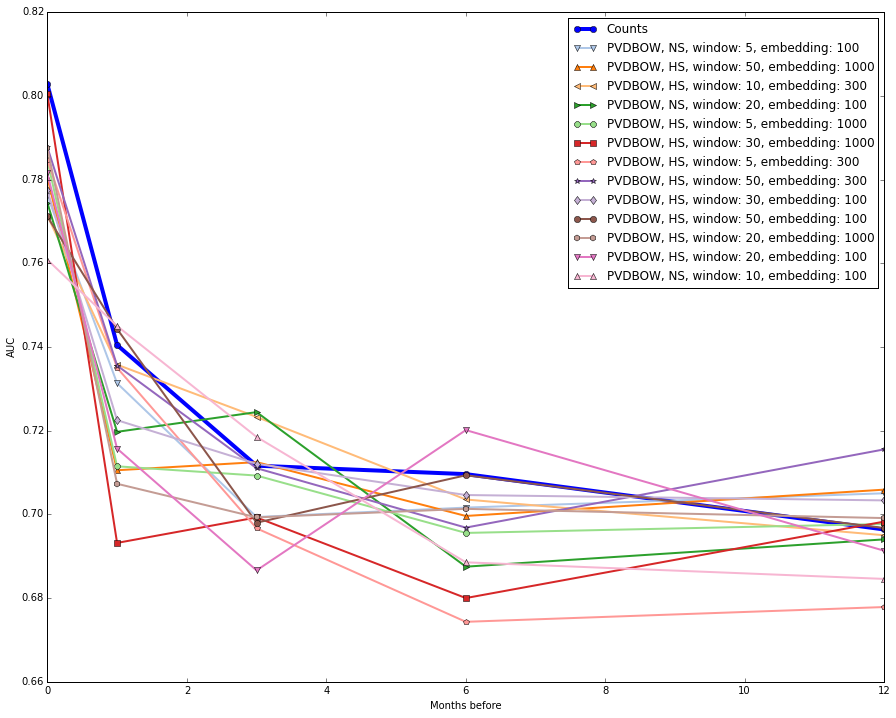

In [4]:
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
markers = "v^<>8sp*dohv^"

plt.plot(counts_results['Months'], counts_results['AUC'], linewidth=4.0, marker="o", label='Counts')

plt.gca().set_color_cycle(['#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728','#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2','#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5'])

for i, model in enumerate(top_models):
    df = vectors_results_model_groups.get_group(model)
    plt.plot(df['Months'], df['AUC'], linewidth=2.0, marker=markers[i], label=get_model_info(model))
plt.legend(loc='upper right')
plt.xlabel('Months before')
plt.ylabel('AUC')
plt.show()

## Learning curves

/Users/jacek/.pyenv/versions/3.5.0/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


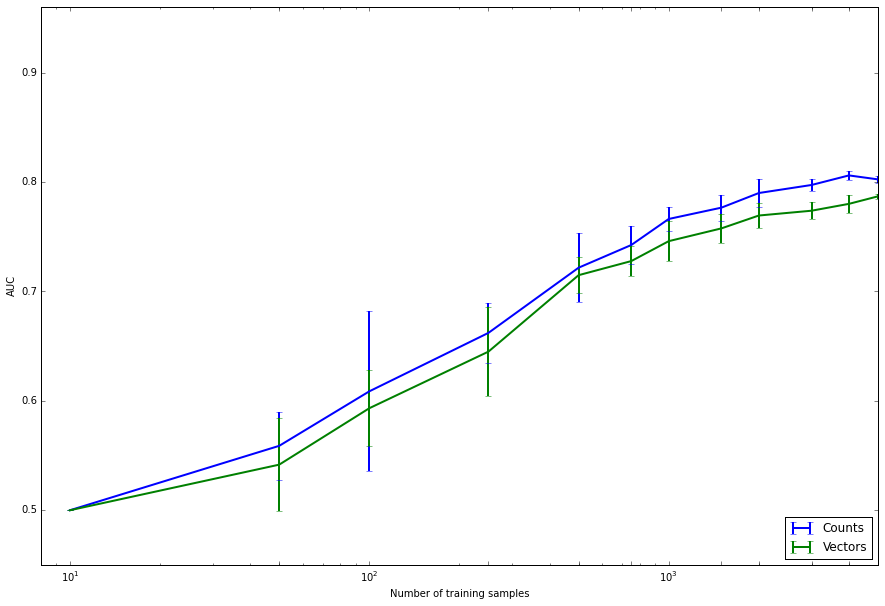

In [5]:
# Counts
lc_counts_df = pd.read_csv('log/lung_cancer_counts_simple_learning_curves.log', header=None)
lc_counts_df.columns = ['samples', 'auc', 'logloss']
lc_counts_sample_groups = lc_counts_df.groupby(by='samples')

samples = []
lc_counts_means = []
lc_counts_stds = []

for g, g_df in lc_counts_sample_groups:
    samples.append(g)
    lc_counts_means.append(g_df['auc'].mean())
    lc_counts_stds.append(g_df['auc'].std())
    
# Vectors

# Vector performace based on patient2vec : PVDBOW, HS, windows size 20, embedding size 100
lc_vectors_df = pd.read_csv('log/lung_cancer_vectors_simple_learning_curves.log', header=None)
lc_vectors_df.columns = ['samples', 'auc', 'logloss']
lc_vectors_sample_groups = lc_vectors_df.groupby(by='samples')

lc_vectors_means = []
lc_vectors_stds = []

for g, g_df in lc_vectors_sample_groups:
    lc_vectors_means.append(g_df['auc'].mean())
    lc_vectors_stds.append(g_df['auc'].std())
    
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

plt.errorbar(samples, lc_counts_means, yerr=lc_counts_stds, label='Counts', linewidth=2.0)
plt.errorbar(samples, lc_vectors_means, yerr=lc_vectors_stds, label='Vectors', linewidth=2.0)
plt.legend(loc='lower right')
plt.xlim((8,2500))
plt.xlabel('Number of training samples')
plt.xscale('log')
plt.xticks(samples)
plt.ylim((0.45,0.96))
plt.ylabel('AUC')
plt.show()

# Discussion

TODO